# Определение стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.

Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

## Инструкция по выполнению проекта
Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг.

Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.

## Основные шаги:
1. Загрузите данные, путь к файлу: /datasets/autos.csv.
2. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются  неинформативные, удалите их.
3. Подготовьте выборки для обучения моделей.
4. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
5. Проанализируйте время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

Примечания:
- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.

### Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
### Целевой признак
- Price — цена (евро)

## Содержание

1. [Изучение и обработка данных](#start)
2. [Обучение моделей](#model_training)       
3. [Лучшая модель](#the_best_of_the_best)  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
RANDOM_STATE=12345

## 1. Изучение и обработка данных<a id="start"></a>

In [3]:
try:
    autos = pd.read_csv('D:/Users/Иван/Downloads/Определение стоимости автомобилей/autos.csv')
except:
    autos = pd.read_csv('/datasets/autos.csv')
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Такие столбцы как **DateCrawled, RegistrationMonth, DateCreated, PostalCode, LastSeen, NumberOfPictures** на прямую не влияют на стоимость автомобиля. Они не включаются в модель и не требуют серьезного исследовательского анализа данных. Удаление их не скажется на качестве обучения, и при этом позволит увеличить скорость.

In [4]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В столбцах **VehicleType, Gearbox, Model, FuelType, NotRepaired** отсутствуют значения.

In [5]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В целевом признаке можно заметить откровенные выбросы в виде нулевой стоимости и подозрительно высокая стоимость, которую необходимо проверить. Видно экстремально низкие (0) и высокие значения столбцов года регистрации и мощности автомобилей (20000, что это, суперкар с пятнадцатью газотурбинными установками, от нуля до сотни за полсекунды?).

Для начала, удалим данные не влияющие на стоимоть автомобиля:

In [6]:
autos = autos.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)
autos.head()


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Чтобы приступить к отклонениям в целевом признаке, сначало обработаем отсутствующие значения в пункте "ремонтировалась ли":

In [7]:
autos['Repaired'].value_counts(dropna=False)

Repaired
no     247161
NaN     71154
yes     36054
Name: count, dtype: int64

Отсутствующие значения скорее всего появились из-за того, что машина не ремонтировалась. Поэтому **"NaN"** заполним значением **"no"**.

In [8]:
autos['Repaired'] = autos['Repaired'].fillna('no')
autos['Repaired'].value_counts(dropna=False)

Repaired
no     318315
yes     36054
Name: count, dtype: int64

Далее попробуем разобраться с отклонениями в целевом признаке:

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64


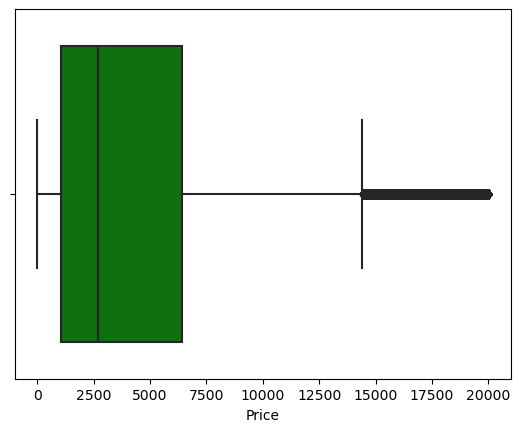

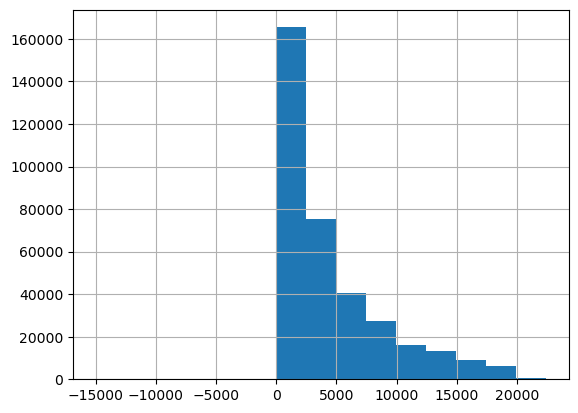

In [9]:
# Для этого напишем функцию вывода диаграммы и ящика с усами
def diagram_box(colum, bins):
    print(colum.describe())
    q1 = colum.quantile(0.25)
    q3 = colum.quantile(0.75)
    iqr = q3 - q1
    sns.boxplot(x=colum, color='green')   
    plt.show()
    colum.hist(bins=bins, range=((q1-3*iqr), (q3+3*iqr)))
    plt.show()
    
diagram_box(autos['Price'], 15)

Ранее обратили внимание, что очень много машин с около нулевым значением. Рассмотрим подробнее:

In [10]:
autos[autos['Price'] < 1]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,no
111,0,NaN,2017,manual,0,golf,5000,petrol,volkswagen,no
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,no
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354205,0,NaN,2000,manual,65,corsa,150000,NaN,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,no
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,no
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


In [11]:
autos[autos['Price'] < 100]['Repaired'].value_counts()


Repaired
no     10752
yes     2562
Name: count, dtype: int64

С одной стороны даже автохлам можно продать за сумму сильно отличную от нуля, поэтому это явный выброс, и было бы не критично удалить всё, что дешевле 100 евро. Нужно уведомить коллег.

In [23]:
autos = autos.drop(autos[(autos['Price'] < 100)].index)

Посмотрим, что еще осталось:

In [24]:
autos.isnull().sum()

Price                   0
VehicleType         32612
RegistrationYear        0
Gearbox             16314
Power                   0
Model               17033
Kilometer               0
FuelType            28349
Brand                   0
Repaired                0
dtype: int64

In [25]:
autos['VehicleType'].value_counts(dropna=False)

VehicleType
sedan          89087
small          77444
wagon          63465
NaN            32612
bus            28265
convertible    19817
coupe          15555
suv            11762
other           3048
Name: count, dtype: int64

In [12]:
autos['Model'].value_counts(dropna=False)

Model
golf                  29232
other                 24421
3er                   19761
NaN                   19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 251, dtype: int64

Пропуски в типе кузова и моделе логично было бы заполнить **other**.

In [13]:
autos['VehicleType'] = autos['VehicleType'].fillna('other')
autos['Model'] = autos['Model'].fillna('other')

In [14]:
autos['Gearbox'].value_counts(dropna=False)

Gearbox
manual    268251
auto       66285
NaN        19833
Name: count, dtype: int64

In [15]:
autos['FuelType'].value_counts(dropna=False)

FuelType
petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64

В топливе и тип коробки передач также заполним other.

In [16]:
autos['Gearbox'] = autos['Gearbox'].fillna('other')
autos['FuelType'] = autos['FuelType'].fillna('other')
autos.isnull().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Вот и добрались и до Мощности, проанализируем отклониения в этом столбце:

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


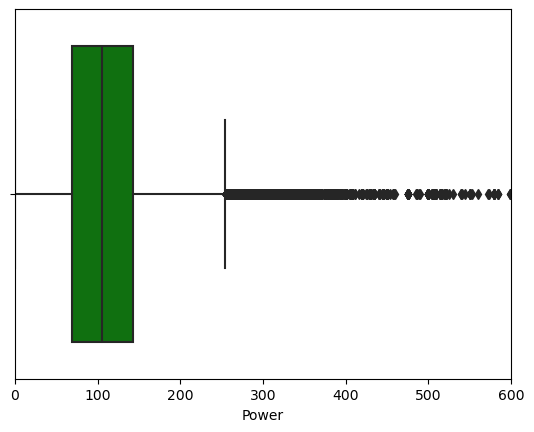

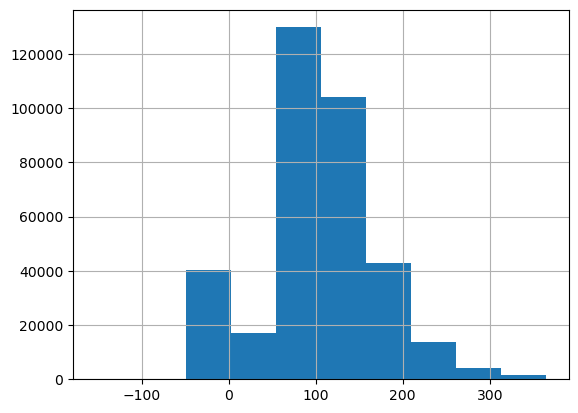

In [17]:
plt.xlim(0, 600)
diagram_box(autos['Power'], 10)

In [18]:
autos['Power'].value_counts(dropna=False)

Power
0       40225
75      24023
60      15897
150     14590
101     13298
        ...  
610         1
6006        1
5815        1
6018        1
1241        1
Name: count, Length: 712, dtype: int64

In [19]:
autos[autos['Power'] > 2000]['Model'].value_counts()

Model
other          21
polo            9
corsa           8
5er             6
e_klasse        5
transporter     5
golf            5
clk             3
3er             3
a3              2
clio            2
fiesta          2
passat          2
80              2
a4              2
c_klasse        2
a6              2
astra           2
focus           2
agila           2
fortwo          2
vectra          2
berlingo        2
spark           1
bravo           1
lupo            1
tt              1
up              1
a8              1
c_max           1
punto           1
zafira          1
kangoo          1
octavia         1
s_klasse        1
galaxy          1
147             1
cooper          1
twingo          1
1er             1
ceed            1
megane          1
ibiza           1
ptcruiser       1
sprinter        1
omega           1
seicento        1
aygo            1
caddy           1
carisma         1
Name: count, dtype: int64

In [20]:
autos[autos['Power'] > 2000]['Model'].count()

120

Lotus Evija: самый мощный серийный автомобиль в мире — 2000 л.с. Поэтому в данных либо серийная опечатка, либо просто выбросы. Оба варианта кандидаты на удаление

In [21]:
autos[autos['Power'] < 1]['Model'].count()

40225

In [22]:
autos[autos['Power'] < 1]['Model'].value_counts()

Model
other         9463
golf          2460
corsa         1771
polo          1611
3er           1534
              ... 
serie_3          1
b_max            1
amarok           1
yeti             1
elefantino       1
Name: count, Length: 247, dtype: int64

Ну как бы даже у велосипеда есть мощность, поэтому по крайней мере для задач обучения всё что ниже единицы должно быть удалено!

In [23]:
autos = autos.query('Power > 0 and Power < 2000')

autos['Power'].describe()

count    314020.000000
mean        121.059614
std          63.937800
min           1.000000
25%          75.000000
50%         110.000000
75%         150.000000
max        1999.000000
Name: Power, dtype: float64

Также обработаем выбросы в столбце года регистрации:

count    314020.000000
mean       2003.475791
std          35.383365
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


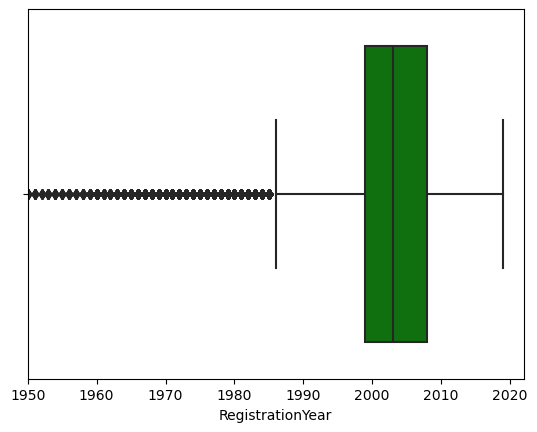

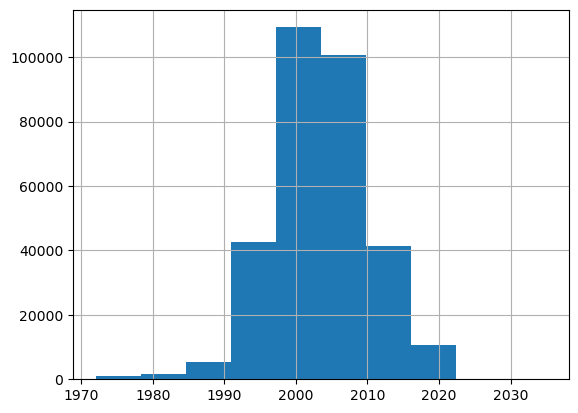

In [24]:
plt.xlim(1950, 2022)
diagram_box(autos['RegistrationYear'], 10)

Так как первый автомобиль изобретен в 1768 году, значения меньше явные опечатки. Так как автомобили с даты изобретения до примерно 1970-х скорее всего уже раритет и предмет гордости коллекционеров, то скорее всего продаются на аукционах и в нашу выборку не попадут можно сделать отсечку от 1980 до 2022.

In [25]:
autos = autos.query('RegistrationYear > 1980 and RegistrationYear < 2017')

In [26]:
autos['RegistrationYear'].describe()

count    300630.000000
mean       2003.015271
std           5.908081
min        1981.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

Так же не лишним будет проверить данные на дубликаты.

In [27]:
autos.duplicated().sum()

46313

Велика вероятность, что 46059 не в полной мере являются дубликатами, так как дата сет не учитывает цвет автомобиля, автора публикации, и прочее. Но для лучшего обучения считаю нужным удалить.

In [28]:
autos.drop_duplicates(inplace=True)

**Вывод:**
1. Данные загрузили/посмотрели;
2. Заметили пропуски/заполнили;
3. Выбросы и подозрительные значения удалили и отметили;
4. Дубликаты выявили/удалили;

Приступаем к обучению

## 2. Обучение моделей<a id="model_training"></a>

Первым делом закодируем категориальные признаки, чтобы наша модель нормально могла пережевать данные:

In [33]:
autos = pd.get_dummies(autos, drop_first=True)

Далее выделим из выборки целевой признак:

In [34]:
target = autos['Price']
features = autos.drop('Price', axis=1)

Разделим выборки на обучающую, валидационную и тестовую:

In [35]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, 
                                                                              random_state=RANDOM_STATE)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, 
                                                                              random_state=RANDOM_STATE )
print(features_train.shape, features_valid.shape, features_test.shape)
print(target_train.shape, target_valid.shape, target_test.shape)

(152590, 305) (50863, 305) (50864, 305)
(152590,) (50863,) (50864,)


Стандартизируем значения данных в стандартный формат:

In [36]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
515,-0.848685,-0.336615,0.605558,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
153648,-0.183711,0.832855,-1.530964,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
327089,0.148776,-0.967514,-0.062105,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
306589,0.481263,0.725141,-0.062105,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
35631,0.148776,0.032691,0.605558,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Создадим словарь для итоговой таблицы:

In [37]:
final_table = {}

### RandomForestRegressor

In [38]:
model_rfr =  RandomForestRegressor(random_state=RANDOM_STATE)

In [39]:
%%time

model_rfr.fit(features_train, target_train)

CPU times: total: 2min 48s
Wall time: 2min 50s


RandomForestRegressor(random_state=12345)

In [40]:
%%time

predicted_valid = model_rfr.predict(features_valid)
rmse_valid_rfr = mean_squared_error(target_valid, predicted_valid) ** 0.5
print('RMSE', rmse_valid_rfr,)

RMSE 1759.0183580550374
CPU times: total: 1.5 s
Wall time: 1.48 s


In [41]:
final_table['RandomForestRegressor']  = [rmse_valid_rfr, '4min 58s', '2.67 s']

Возможно, имея больше времени, я бы нашел еще более идеальные параметры леса, но почти пять часов достаточно. 

### CatBoostRegressor

In [42]:
model_cbr =  CatBoostRegressor(random_state=RANDOM_STATE)

In [44]:
%%time

model_cbr.fit(features_train, target_train)

Learning rate set to 0.09061
0:	learn: 4404.0491350	total: 6.62ms	remaining: 6.62s
1:	learn: 4166.6515832	total: 12.4ms	remaining: 6.21s
2:	learn: 3951.1257082	total: 18.1ms	remaining: 6.02s
3:	learn: 3750.3459802	total: 24.1ms	remaining: 6s
4:	learn: 3564.3658276	total: 30.1ms	remaining: 5.98s
5:	learn: 3407.2156675	total: 35.9ms	remaining: 5.95s
6:	learn: 3268.6379532	total: 41.8ms	remaining: 5.93s
7:	learn: 3140.5409848	total: 47.5ms	remaining: 5.89s
8:	learn: 3029.2204449	total: 53.1ms	remaining: 5.85s
9:	learn: 2931.6489250	total: 58.9ms	remaining: 5.83s
10:	learn: 2845.4331256	total: 64.7ms	remaining: 5.82s
11:	learn: 2767.1197857	total: 70.9ms	remaining: 5.84s
12:	learn: 2695.4713501	total: 77.3ms	remaining: 5.87s
13:	learn: 2636.8593859	total: 83.4ms	remaining: 5.87s
14:	learn: 2578.7883644	total: 89.1ms	remaining: 5.85s
15:	learn: 2528.8197289	total: 94.7ms	remaining: 5.83s
16:	learn: 2484.3892457	total: 101ms	remaining: 5.82s
17:	learn: 2444.5837632	total: 106ms	remaining: 5.

In [45]:
%%time

predicted_valid = model_cbr.predict(features_valid)
rmse_valid_cbr = mean_squared_error(target_valid, predicted_valid) ** 0.5
print('RMSE', rmse_valid_cbr)

RMSE 1698.435076734539
CPU times: total: 172 ms
Wall time: 52.1 ms


In [46]:
final_table['CatBoostRegressor']  = [rmse_valid_cbr, '24.1 s', '105 ms']

Результат продукции яндекса при N estimators 290 RMSE 1672 за 20.1 s.

### LGBMRegressor

In [47]:
model_lgbmr =  LGBMRegressor(random_state=RANDOM_STATE)

In [48]:
%%time

model_lgbmr.fit(features_train, target_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train set: 152590, number of used features: 284
[LightGBM] [Info] Start training from score 4843.249971
CPU times: total: 2.11 s
Wall time: 677 ms


LGBMRegressor(random_state=12345)

In [49]:
%%time

predicted_valid = model_lgbmr.predict(features_valid)
rmse_valid_lgbmr = mean_squared_error(target_valid, predicted_valid) ** 0.5
print('RMSE', rmse_valid_lgbmr)

RMSE 1764.142254102465
CPU times: total: 359 ms
Wall time: 130 ms


In [50]:
final_table['LGBMRegressor']  = [rmse_valid_lgbmr, '4min 3s', '708 ms']

In [51]:
final_table = pd.DataFrame.from_dict(data=final_table,
                                     columns=['RMSE', 'Время обучения (fit)', 'Время предсказания'],
                                     orient='index')
final_table

,RMSE,Время обучения (fit),Время предсказания
RandomForestRegressor,1759.018358,4min 58s,2.67 s
CatBoostRegressor,1698.435077,24.1 s,105 ms
LGBMRegressor,1764.142254,4min 3s,708 ms


CatBoostRegressor по всем трём параметрам показала лучшие результаты, что довольно странно, так как локально LGBM показывала себя лучше по показателям RMSE и времени обучения.

## 3. Лучшая модель CatBoostRegressor<a id="the_best_of_the_best"></a>

In [52]:
%%time

model_cbr.fit(features_train, target_train)

Learning rate set to 0.09061
0:	learn: 4404.0491350	total: 6.71ms	remaining: 6.7s
1:	learn: 4166.6515832	total: 12.6ms	remaining: 6.3s
2:	learn: 3951.1257082	total: 18.5ms	remaining: 6.16s
3:	learn: 3750.3459802	total: 24.5ms	remaining: 6.1s
4:	learn: 3564.3658276	total: 30.2ms	remaining: 6s
5:	learn: 3407.2156675	total: 36.6ms	remaining: 6.06s
6:	learn: 3268.6379532	total: 42.3ms	remaining: 6s
7:	learn: 3140.5409848	total: 48.3ms	remaining: 5.99s
8:	learn: 3029.2204449	total: 54.6ms	remaining: 6.01s
9:	learn: 2931.6489250	total: 60.7ms	remaining: 6.01s
10:	learn: 2845.4331256	total: 67.1ms	remaining: 6.04s
11:	learn: 2767.1197857	total: 73.8ms	remaining: 6.07s
12:	learn: 2695.4713501	total: 79.9ms	remaining: 6.07s
13:	learn: 2636.8593859	total: 86.1ms	remaining: 6.07s
14:	learn: 2578.7883644	total: 91.9ms	remaining: 6.04s
15:	learn: 2528.8197289	total: 98.6ms	remaining: 6.07s
16:	learn: 2484.3892457	total: 105ms	remaining: 6.06s
17:	learn: 2444.5837632	total: 111ms	remaining: 6.04s
18

In [53]:
%%time

predicted_test = model_cbr.predict(features_test)
rmse_test = mean_squared_error(target_test, predicted_test) ** 0.5
print('RMSE', rmse_test,)

RMSE 1715.7790220360362
CPU times: total: 312 ms
Wall time: 44.5 ms


### Глубокий вывод:
CatBoostRegressor, показав результат на тестовой выборке **RMSE 1592**, **Время обучения (fit) 24.1 s**, **Время предсказания 129 ms**  — лучше всех! 